# $S_0$ Schnittstelle des eHz auslesen

* S0 Wiki: https://de.wikipedia.org/wiki/S0-Schnittstelle
* Terminal Wiki: http://www.tldp.org/HOWTO/Text-Terminal-HOWTO-15.html
* RPi Serial: https://elinux.org/RPi_Serial_Connection

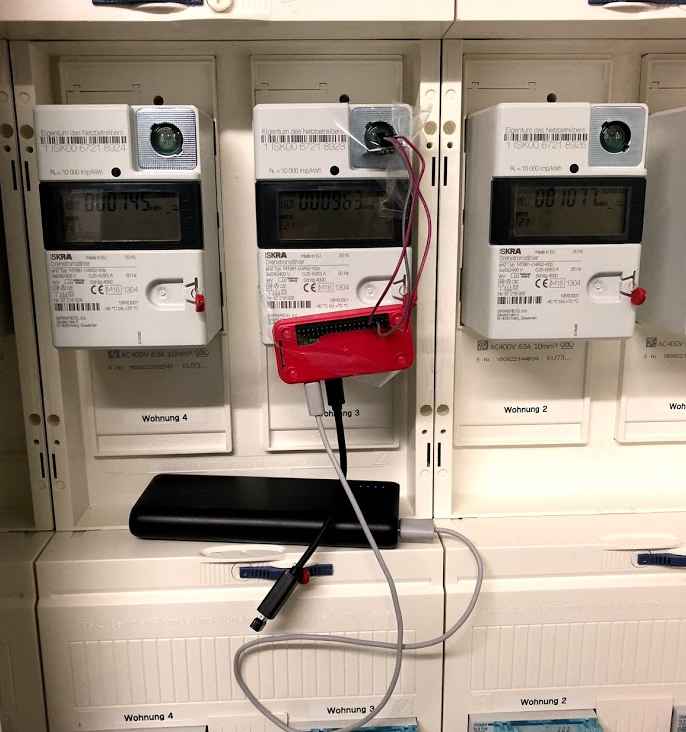

Der IR Kopf hängt über die serielle Schnittstelle des Raspberry an `/dev/serial0`. Da wir die $S_0$ Schnittstelle des Stromzählers benutzen (anders als im Bild) sind 10.000 Impulse 1kWh. Um live mitzulesen nutzen wir ein `bash` Skript.

`stty time 1 min 1 -icanon < /dev/serial0`

https://social.msdn.microsoft.com/Forums/vstudio/en-US/fe68e7aa-d9d6-406c-b663-4d52f759dbab/receive-wrong-caracters-from-serial-port?forum=vbgeneral

CLI des Raspberry Zero W:   
`strace -ttt -o /home/pi/Desktop/smartmeter.txt -e write cat < /dev/serial0 2>&1`

In [ ]:
# Alternativ könnten wir auch ein Python Programm schreiben, das wir auf dem Raspberry ausführen um die serielle Schnittstelle auszulesen.
import serial
import csv
import datetime

serialport = serial.Serial("/dev/serial0", 9600, timeout=0.5)

with open("smartmeter.csv", "a") as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=' ', quotechar='|')
    
    while True:    
        value = serialport.read()
        csvwriter.writerow([str(datetime.datetime.now()), str(value)])

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.style.use('ggplot')

In [3]:
smartmeter_df = pd.read_csv(r"C:/Users/Andreas.Hopfgartner/Desktop/smartmeter.txt", header=None, delim_whitespace=True).drop(columns=[1,2,3,4])
smartmeter_df.columns = ["timestamp", "value"]
smartmeter_df["timestamp"] = pd.to_datetime(smartmeter_df["timestamp"], origin='unix', unit="s")
smartmeter_df.set_index("timestamp", inplace=True)
smartmeter_df = smartmeter_df[smartmeter_df.value == '1']
smartmeter_df["value"] = pd.to_numeric(smartmeter_df["value"])

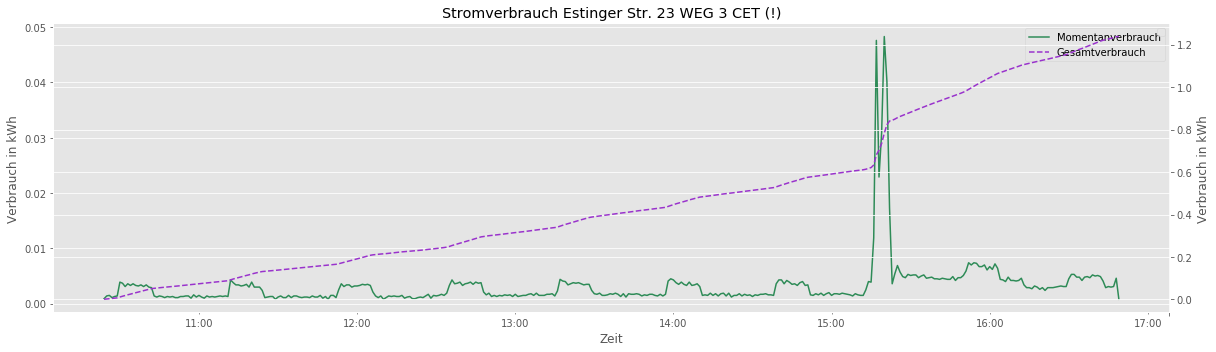

In [4]:
fig, ax1 = plt.subplots(figsize=(17,5))
smartmeter_df.resample("min").sum().divide(10000, axis="value").plot(y="value", ax=ax1, color="seagreen", label="Momentanverbrauch")

ax2 = ax1.twinx()
smartmeter_df.resample("min").sum().cumsum().divide(10000, axis="value").plot(y="value", style='--',ax=ax2, color="darkorchid", label="Gesamtverbrauch")

lns = ax1.lines + ax2.lines
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
ax2.legend([])

ax1.set_ylabel("Verbrauch in kWh")
ax2.set_ylabel("Verbrauch in kWh")
ax1.set_xlabel("Zeit")
ax1.set_title("Stromverbrauch Estinger Str. 23 WEG 3 CET (!)")

fig.tight_layout()

Überprüfen mit 2x Werte ablesen und Plausicheck!